# Dataset (Image) Diagnostics

Image shape: (1436, 1754)
Data type: uint8
Min intensity: 0
Max intensity: 250


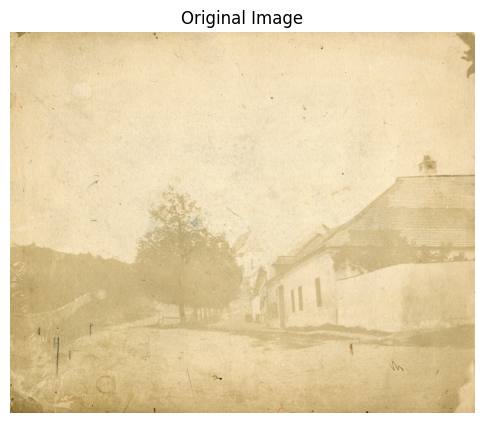

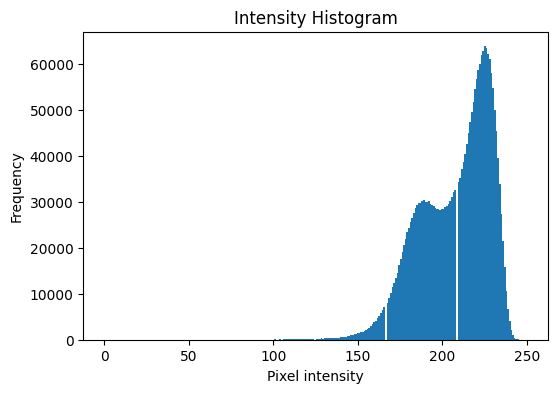

In [32]:
# Figure 1: Original historical photograph of Svätý Jur (circa 1880) (Section 1.1)
# Figure 2: Intensity histogram of grayscale image (Section 1.2)
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load grayscale image for analysis
img = cv2.imread("data/image.png", cv2.IMREAD_GRAYSCALE)

# Load original image (color) for display only
img_color = cv2.imread("data/image.png")
img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

print("Image shape:", img.shape)
print("Data type:", img.dtype)
print("Min intensity:", img.min())
print("Max intensity:", img.max())

# Display original color image
plt.figure(figsize=(6,6))
plt.imshow(img_color)
plt.title("Original Image")
plt.axis("off")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(img.ravel(), bins=256)
plt.title("Intensity Histogram")
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")

plt.savefig("figures/intensity_histogram.png")
plt.show()


# Section 4.1 — Denoising

We apply three classical denoising methods (Gaussian, Median, Bilateral) to the historical photo.
We focus on qualitative comparison: noise suppression vs edge/detail preservation.


In [33]:
###Denoising (baseline parameters)

# Gaussian blur: kernel size must be odd
gauss_k = 5
gauss_sigma = 0  # 0 lets OpenCV choose sigma based on kernel
img_gauss = cv2.GaussianBlur(img, (gauss_k, gauss_k), gauss_sigma)

# Median blur: ksize must be odd
med_k = 5
img_median = cv2.medianBlur(img, med_k)

# Bilateral filter: edge-preserving smoothing
# d = neighborhood diameter; sigmaColor controls intensity similarity; sigmaSpace controls spatial extent
bil_d = 9
bil_sigmaColor = 50
bil_sigmaSpace = 50
img_bilat = cv2.bilateralFilter(img, d=bil_d, sigmaColor=bil_sigmaColor, sigmaSpace=bil_sigmaSpace)


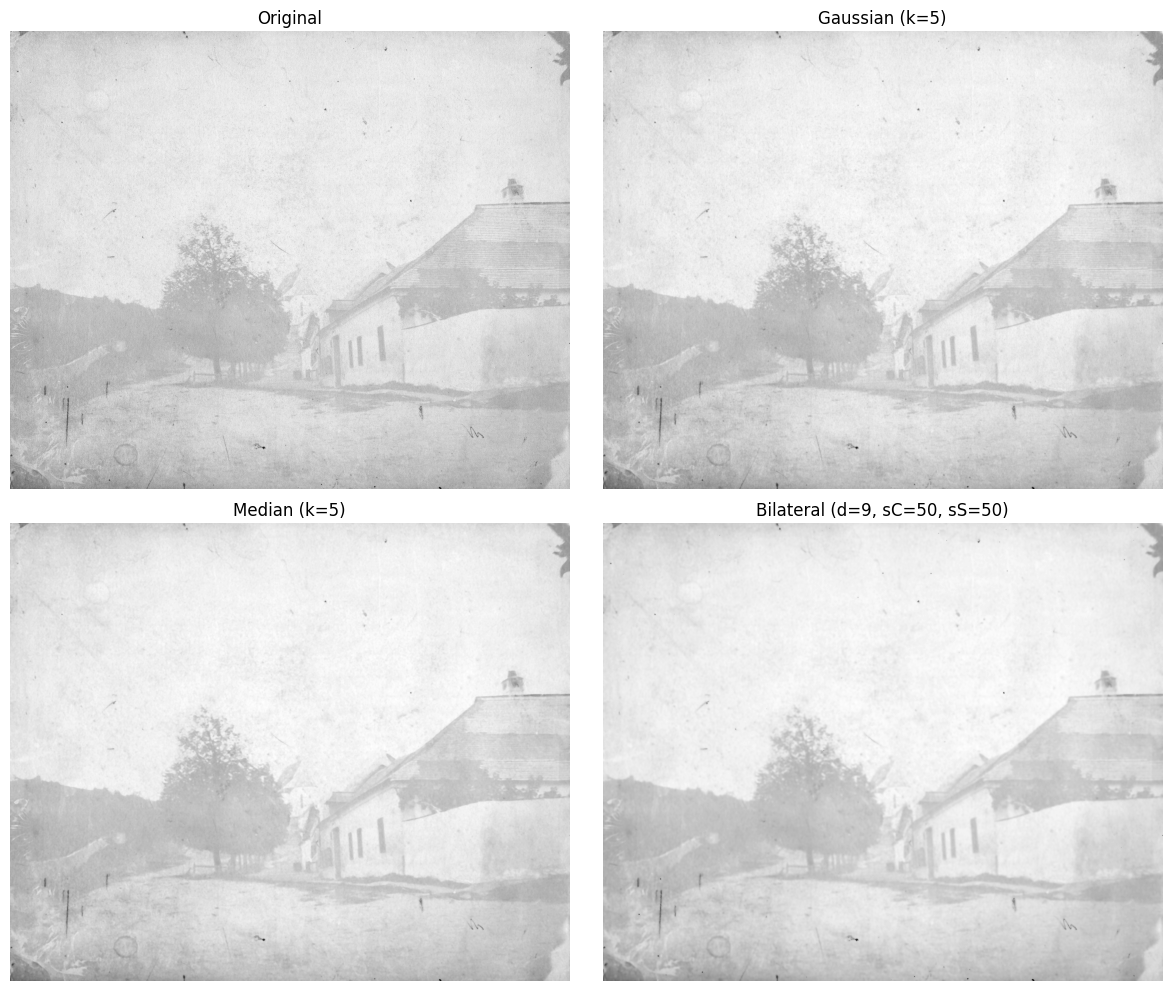

In [34]:
# Figure 3: Comparison of denoising methods (original, Gaussian, median, bilateral) (Section 4.1)
def show_grid(images, titles, cols=2, figsize=(10,10), cmap="gray", save_path=None):
    rows = int(np.ceil(len(images)/cols))
    plt.figure(figsize=figsize)
    for i, (im, t) in enumerate(zip(images, titles), 1):
        ax = plt.subplot(rows, cols, i)
        ax.imshow(im, cmap=cmap)
        ax.set_title(t)
        ax.axis("off")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

images = [img, img_gauss, img_median, img_bilat]
titles = [
    "Original",
    f"Gaussian (k={gauss_k})",
    f"Median (k={med_k})",
    f"Bilateral (d={bil_d}, sC={bil_sigmaColor}, sS={bil_sigmaSpace})"
]
show_grid(images, titles, cols=2, figsize=(12,10), save_path="figures/fig_denoising_comparison.png")


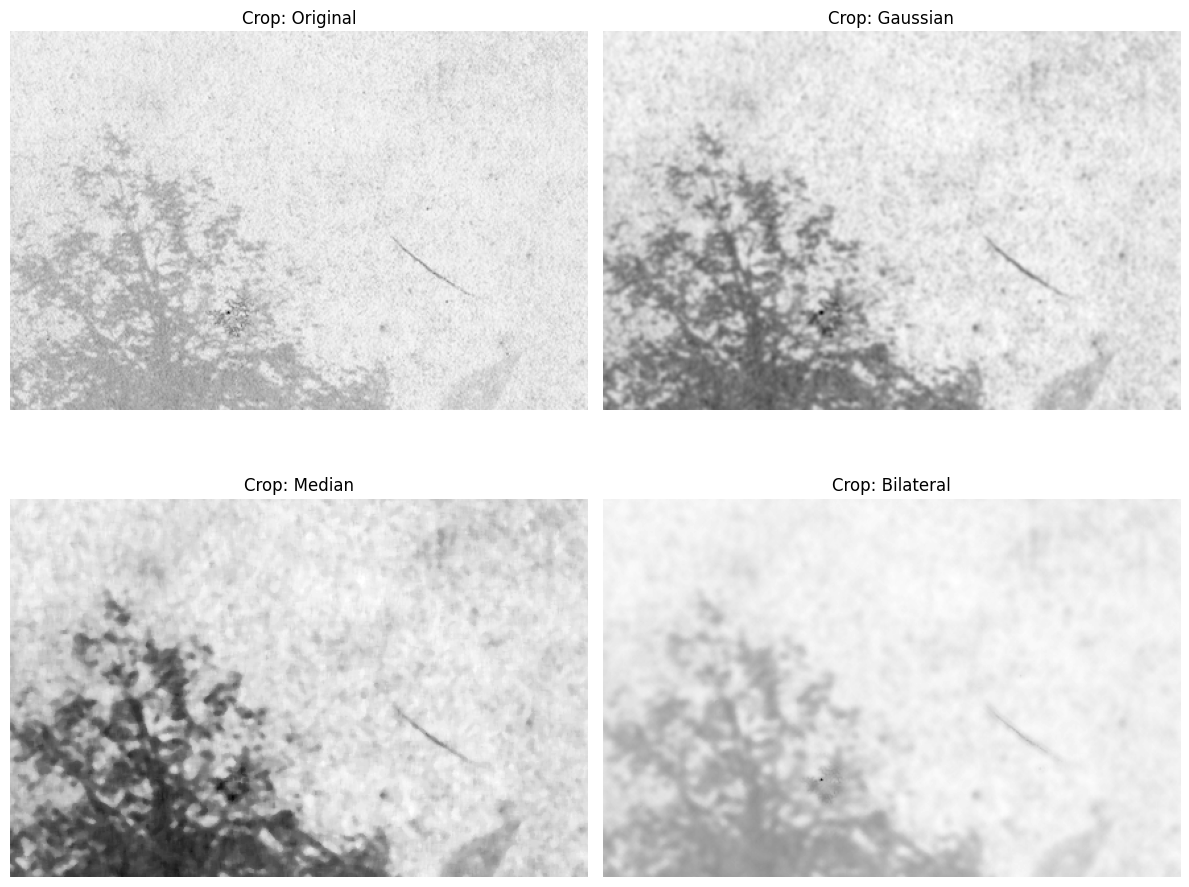

In [35]:
# Figure 4: Zoomed-in comparison of denoising methods on representative crop region (Section 4.1)
# Choose a crop region where there are edges + texture 
h, w = img.shape
x1, x2 = int(0.30*w), int(0.55*w)
y1, y2 = int(0.35*h), int(0.55*h)

crop = img[y1:y2, x1:x2]
crop_gauss = img_gauss[y1:y2, x1:x2]
crop_median = img_median[y1:y2, x1:x2]
crop_bilat = img_bilat[y1:y2, x1:x2]

images = [crop, crop_gauss, crop_median, crop_bilat]
titles = ["Crop: Original", "Crop: Gaussian", "Crop: Median", "Crop: Bilateral"]
show_grid(images, titles, cols=2, figsize=(12,10), save_path="figures/fig_denoising_crop.png")


# Section 4.2 — Edge Detection

We compare Sobel, Laplacian, and Canny edge detection on:
(1) original image and (2) denoised variants (Gaussian, Median, Bilateral).
Goal: understand sensitivity to noise, edge localization, and continuity.


In [36]:
### Helper functions for edges + plotting

def sobel_edges(img):
    # Sobel gradients
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    mag = np.sqrt(gx**2 + gy**2)

    # Normalize to 0–255 for display
    mag = (mag / (mag.max() + 1e-9) * 255).astype(np.uint8)
    return mag

def laplacian_edges(img):
    lap = cv2.Laplacian(img, cv2.CV_64F, ksize=3)
    lap_abs = np.abs(lap)
    lap_abs = (lap_abs / (lap_abs.max() + 1e-9) * 255).astype(np.uint8)
    return lap_abs

def canny_edges(img, low=50, high=150):
    return cv2.Canny(img, threshold1=low, threshold2=high)

def show_grid(images, titles, cols=4, figsize=(16,10), cmap="gray", save_path=None):
    rows = int(np.ceil(len(images)/cols))
    plt.figure(figsize=figsize)
    for i, (im, t) in enumerate(zip(images, titles), 1):
        ax = plt.subplot(rows, cols, i)
        ax.imshow(im, cmap=cmap)
        ax.set_title(t, fontsize=10)
        ax.axis("off")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


In [37]:
### Comute edges for each input

inputs = {
    "Original": img,
    "Gaussian": img_gauss,
    "Median": img_median,
    "Bilateral": img_bilat
}

# Compute edge maps
edges_sobel = {name: sobel_edges(im) for name, im in inputs.items()}
edges_lap   = {name: laplacian_edges(im) for name, im in inputs.items()}

# Start with default Canny thresholds
canny_low, canny_high = 50, 150
edges_canny = {name: canny_edges(im, low=canny_low, high=canny_high) for name, im in inputs.items()}


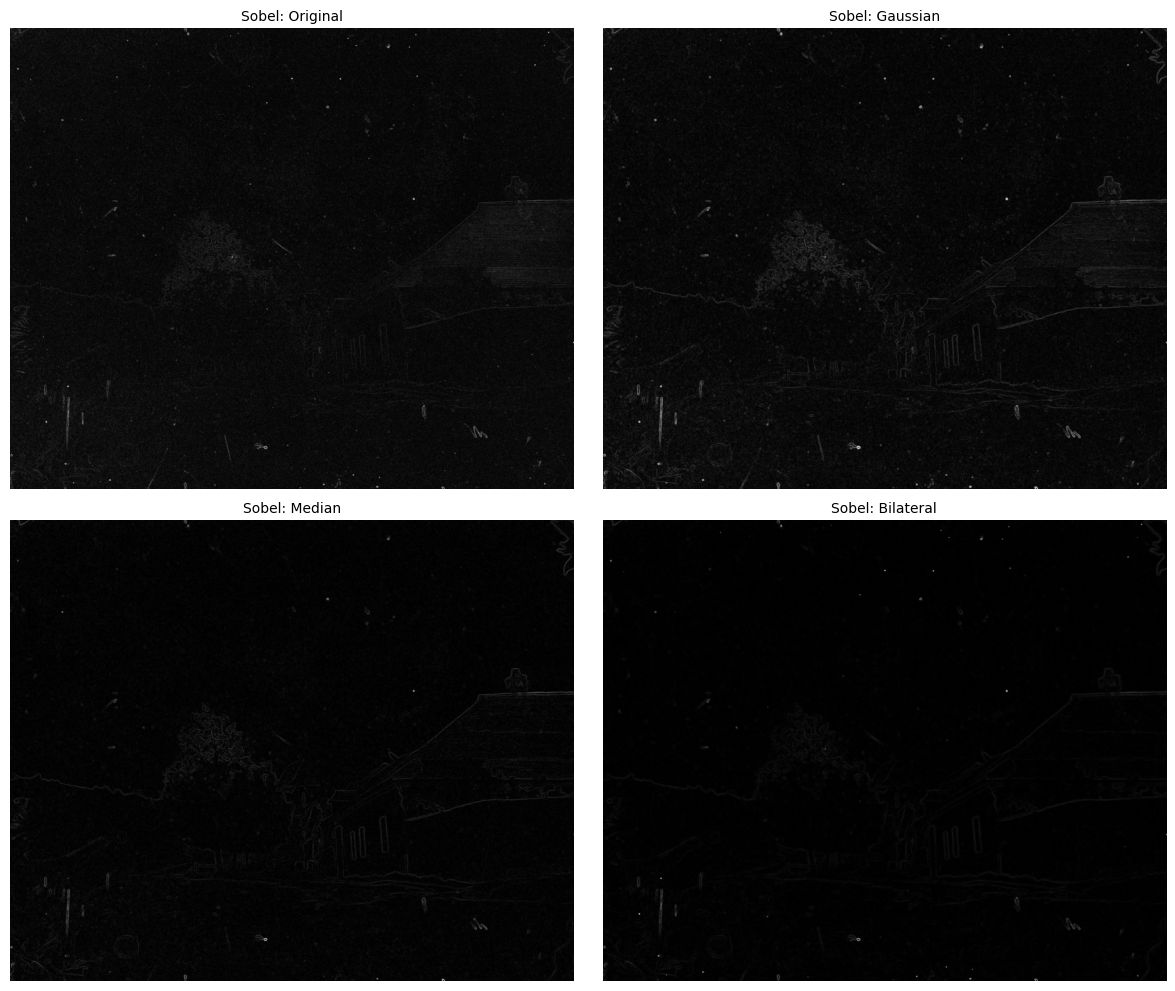

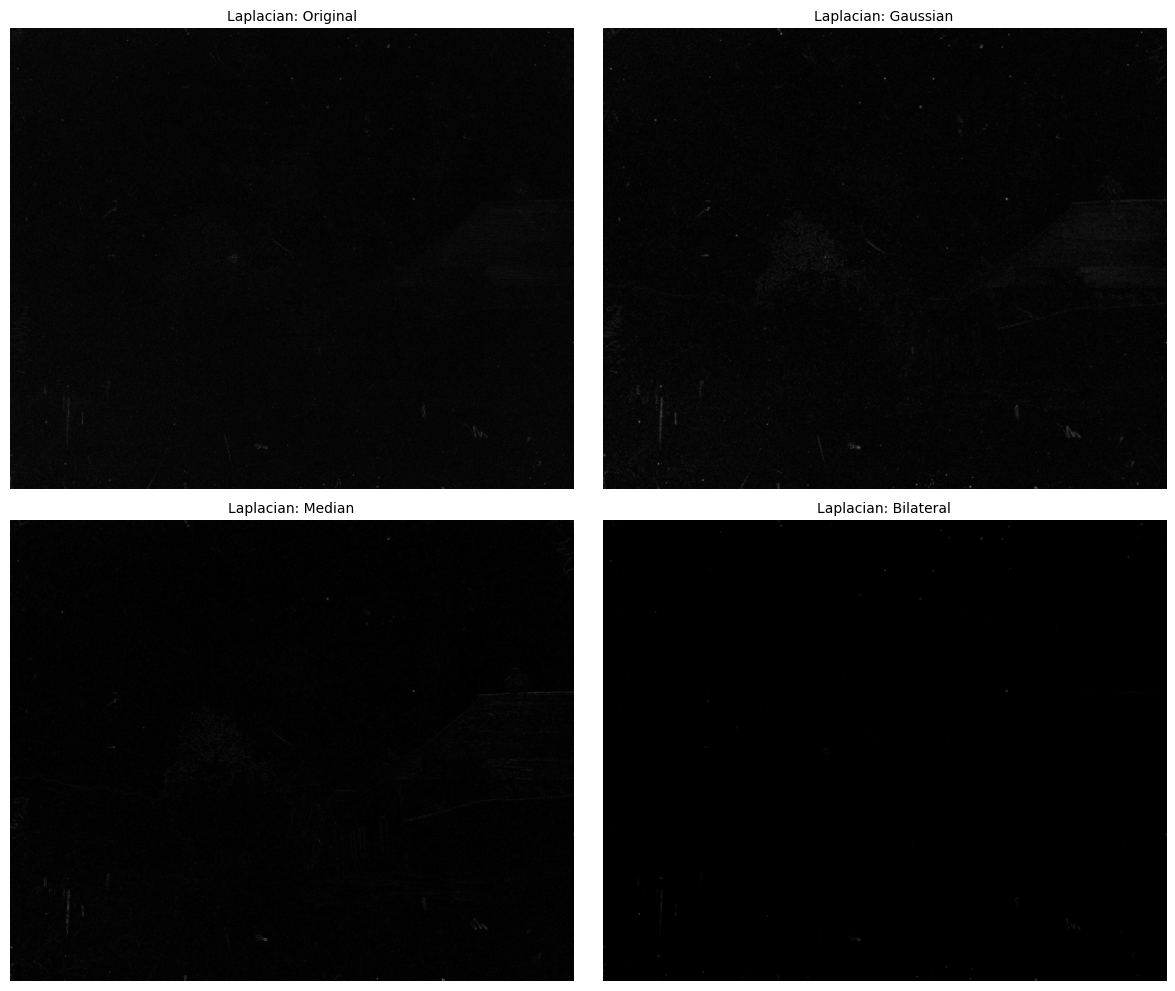

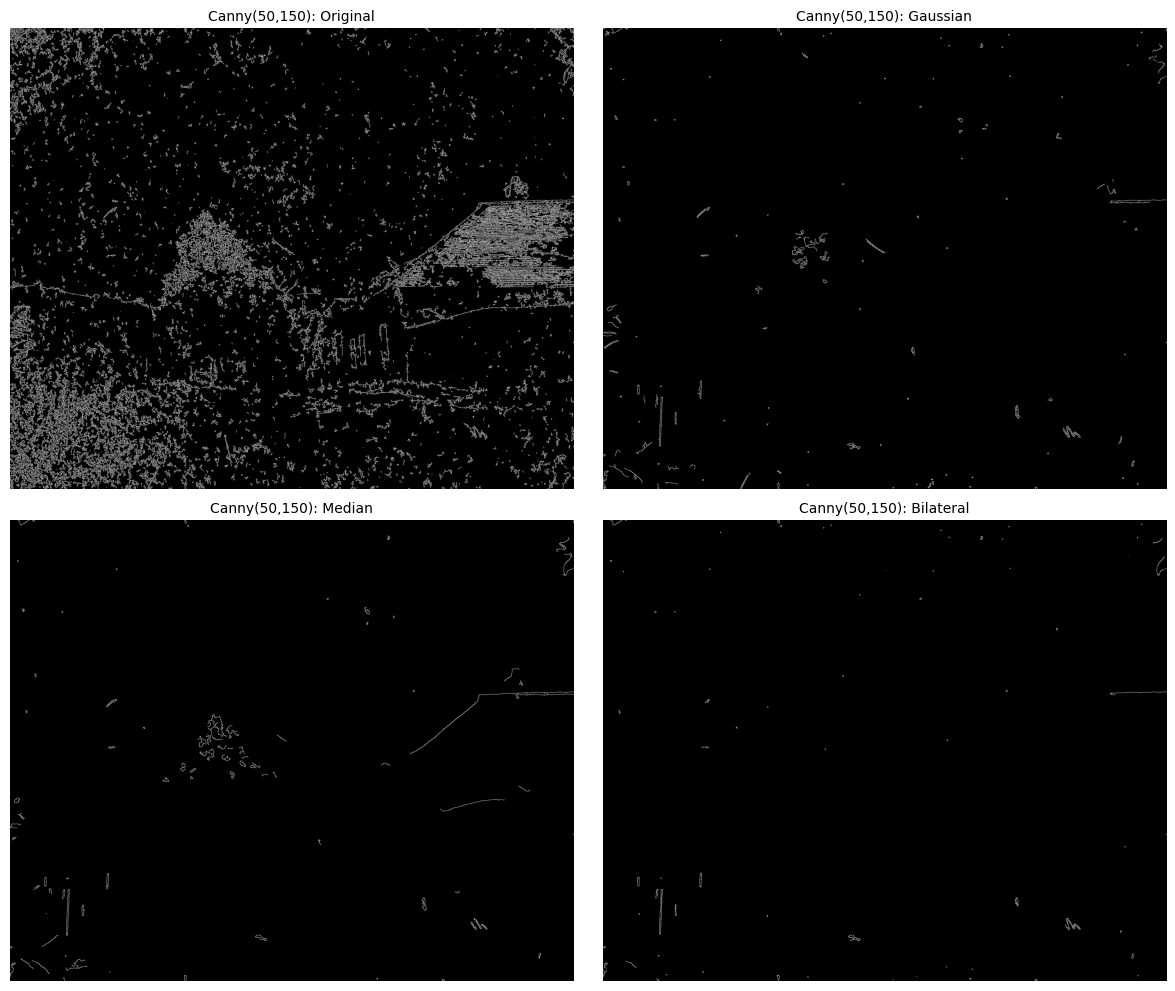

In [38]:
### Comparison figures
# Figure 5: Sobel edge detection applied to original and denoised images (Section 4.2)
# For report figures unused Laplacian detection applied to original and denoised images
# Figure 6: Canny edge detection with standard thresholds (50,150) (Section 4.2)
# Figure 7: Best-performing edge detection — Sobel after Gaussian smoothing (Section 4.2) (screenshot from figure 5)


# Sobel
images = [edges_sobel[k] for k in inputs.keys()]
titles = [f"Sobel: {k}" for k in inputs.keys()]
show_grid(images, titles, cols=2, figsize=(12,10), save_path="figures/fig_edges_sobel.png")

# Laplacian
images = [edges_lap[k] for k in inputs.keys()]
titles = [f"Laplacian: {k}" for k in inputs.keys()]
show_grid(images, titles, cols=2, figsize=(12,10), save_path="figures/fig_edges_laplacian.png")

# Canny
images = [edges_canny[k] for k in inputs.keys()]
titles = [f"Canny({canny_low},{canny_high}): {k}" for k in inputs.keys()]
show_grid(images, titles, cols=2, figsize=(12,10), save_path="figures/fig_edges_canny.png")



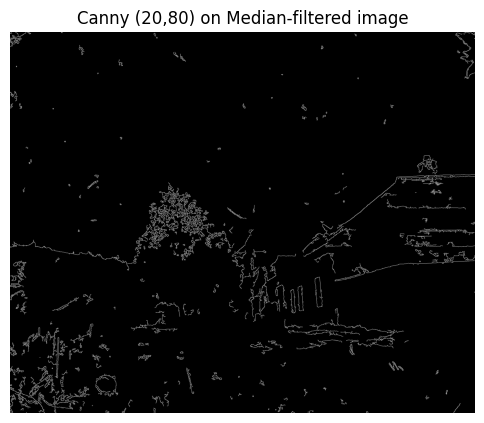

True

In [39]:
# Figure 8: Canny edge detection with lower thresholds (20,80) showing noise trade-off (Section 4.2)
# Canny with lower thresholds to recover weak edges
edges_canny_lo = cv2.Canny(img_median, 20, 80)

plt.figure(figsize=(6,6))
plt.imshow(edges_canny_lo, cmap="gray")
plt.title("Canny (20,80) on Median-filtered image")
plt.axis("off")
plt.show()

cv2.imwrite("figures/fig_edges_canny_low.png", edges_canny_lo)


# Section 4.3 — Segmentation

We attempt to segment meaningful regions (foreground structures vs background) using:
1) Global thresholding (Otsu and manual)
2) Adaptive thresholding (local)
3) Morphological cleanup + connected components

Goal: evaluate what is and is not recoverable from a degraded historical photograph.


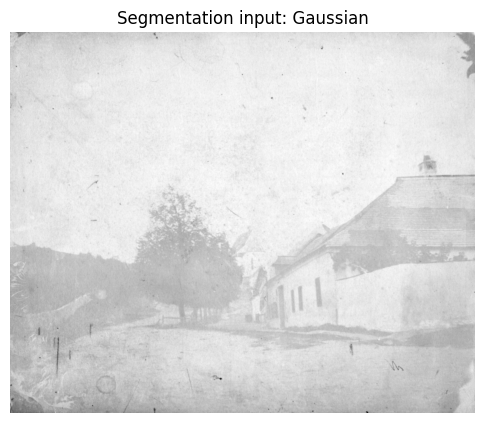

In [40]:
# Choose input for segmentation
seg_in = img_gauss   
seg_name = "Gaussian"

plt.figure(figsize=(6,6))
plt.imshow(seg_in, cmap="gray")
plt.axis("off")
plt.title(f"Segmentation input: {seg_name}")
plt.show()

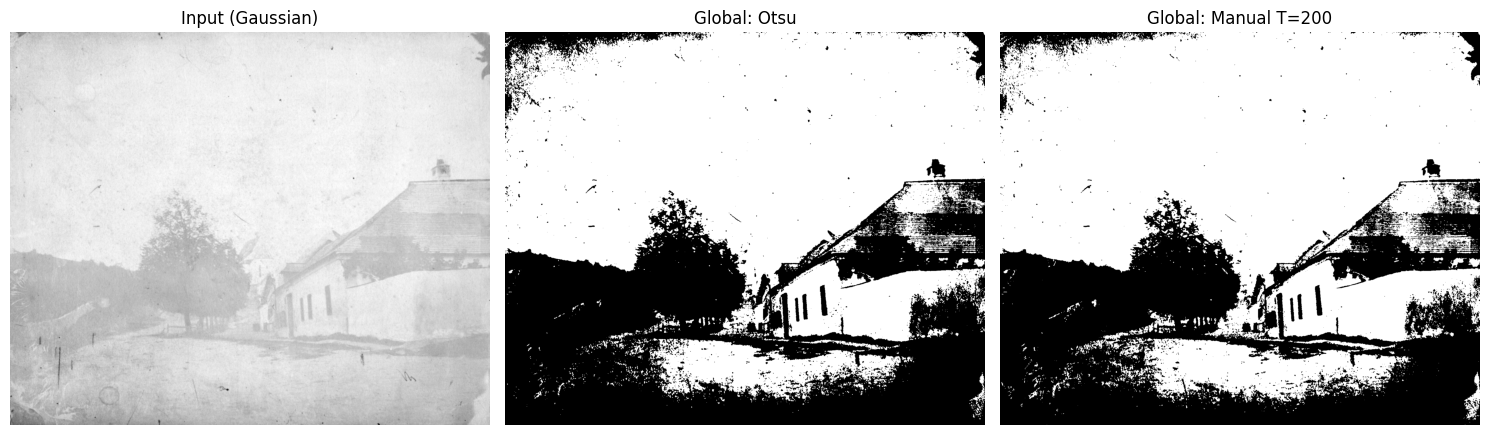

Otsu threshold value: 203.0


In [41]:
###Global thresholding
# Figure 9: Global thresholding of Gaussian-smoothed image (Otsu and manual threshold) (Section 4.3)

# Otsu threshold (automatic)
_, thr_otsu = cv2.threshold(seg_in, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Manual threshold (choose something around the valley in histogram)
T = 200  
_, thr_manual = cv2.threshold(seg_in, T, 255, cv2.THRESH_BINARY)

# Visual comparison
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(seg_in, cmap="gray"); axs[0].set_title(f"Input ({seg_name})"); axs[0].axis("off")
axs[1].imshow(thr_otsu, cmap="gray"); axs[1].set_title("Global: Otsu"); axs[1].axis("off")
axs[2].imshow(thr_manual, cmap="gray"); axs[2].set_title(f"Global: Manual T={T}"); axs[2].axis("off")
plt.tight_layout()
plt.savefig("figures/fig_seg_global.png", dpi=200, bbox_inches="tight")
plt.show()

print("Otsu threshold value:", cv2.threshold(seg_in, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0])


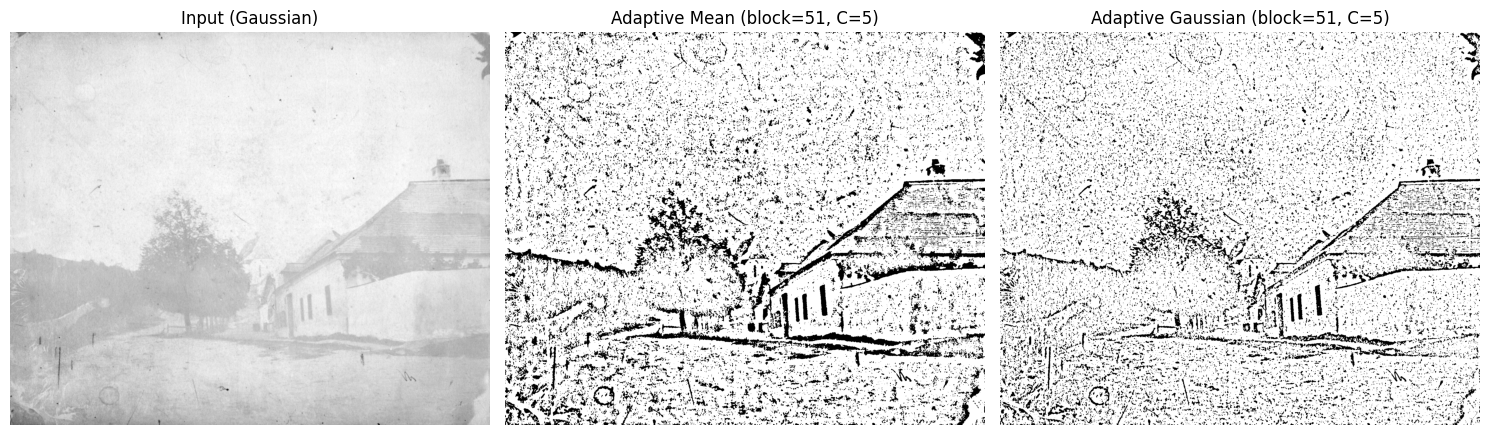

In [42]:
### Adaptive thresholding
# Figure 10: Adaptive thresholding results (mean and Gaussian local thresholds) (Section 4.3)

# blockSize must be odd; C is subtracted from the mean/weighted mean
blockSize = 51
C = 5

thr_adapt_mean = cv2.adaptiveThreshold(
    seg_in, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize, C
)

thr_adapt_gauss = cv2.adaptiveThreshold(
    seg_in, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C
)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(seg_in, cmap="gray"); axs[0].set_title(f"Input ({seg_name})"); axs[0].axis("off")
axs[1].imshow(thr_adapt_mean, cmap="gray"); axs[1].set_title(f"Adaptive Mean (block={blockSize}, C={C})"); axs[1].axis("off")
axs[2].imshow(thr_adapt_gauss, cmap="gray"); axs[2].set_title(f"Adaptive Gaussian (block={blockSize}, C={C})"); axs[2].axis("off")
plt.tight_layout()
plt.savefig("figures/fig_seg_adaptive.png", dpi=200, bbox_inches="tight")
plt.show()


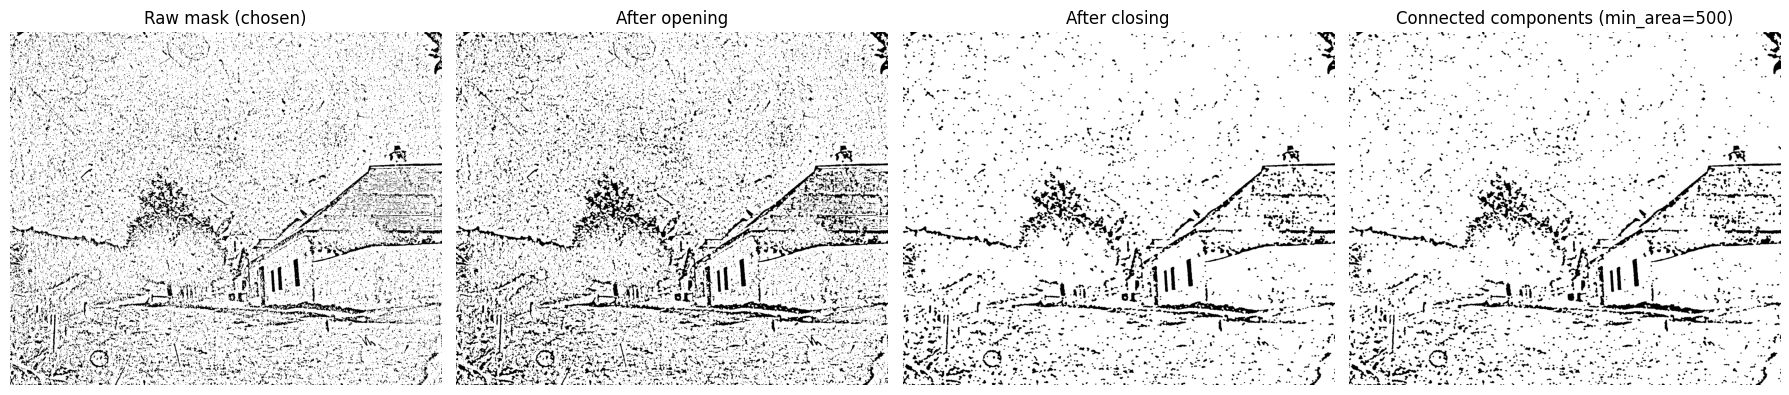

Connected components found (excluding background): 37


In [46]:
# Figure 11: Segmentation refinement using morphological cleanup and connected components (Section 4.3)

# Choose which binary mask to clean up:
mask = thr_adapt_gauss.copy()

### Morphological operations 
# Opening removes small white specks; closing fills small holes in white regions.
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))

mask_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
mask_close = cv2.morphologyEx(mask_open, cv2.MORPH_CLOSE, kernel, iterations=1)

### Connected components (remove tiny components)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_close, connectivity=8)

# Remove components smaller than a threshold area
min_area = 500 # Can be adjustd based on specle size
mask_cc = np.zeros_like(mask_close)
for lab in range(1, num_labels):
    area = stats[lab, cv2.CC_STAT_AREA]
    if area >= min_area:
        mask_cc[labels == lab] = 255

fig, axs = plt.subplots(1, 4, figsize=(18,5))
axs[0].imshow(mask, cmap="gray"); axs[0].set_title("Raw mask (chosen)"); axs[0].axis("off")
axs[1].imshow(mask_open, cmap="gray"); axs[1].set_title("After opening"); axs[1].axis("off")
axs[2].imshow(mask_close, cmap="gray"); axs[2].set_title("After closing"); axs[2].axis("off")
axs[3].imshow(mask_cc, cmap="gray"); axs[3].set_title(f"Connected components (min_area={min_area})"); axs[3].axis("off")
plt.tight_layout()
plt.savefig("figures/fig_seg_cleanup_cc.png", dpi=200, bbox_inches="tight")
plt.show()

print("Connected components found (excluding background):", num_labels-1)
